# Ion-Beam Targeting Optimization with Machine Learning

### Descripción
This project analyzes beam–target interactions during the implantation of Se-80 and Se-82 isotopes into a carbon target coated with a thin gold film, mounted on an aluminum frame.

During the experiment at the LEMA accelerator (IFUNAM), it was observed that part of the ion beam impacted not only the target but also the surrounding aluminum frame. A numerical solution related to the “goat grazing problem” was used to model this behavior.

Based on this solution, a machine learning model is proposed to distinguish between beam components striking the isotopically pure target and those hitting the aluminum frame, with the objective of beam optimization and experimental efficiency improvement. The labels are:

*  0 = Frame interactions

*  1 = Target interactions and noise

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.integrate import trapezoid
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

## Funciones axiliares

In [2]:
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
    strat = df[stratify] if stratify else None
    train_set, test_set = train_test_split(
        df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
    strat = test_set[stratify] if stratify else None
    val_set, test_set = train_test_split(
        test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
    return (train_set, val_set, test_set)

In [3]:
# Función que separa las variables de entrada y salida
def remove_labels(df, label_name):
    X = df.drop(label_name, axis=1)
    y = df[label_name].copy()
    return (X, y)

# Logistic Regression

## 1. Lectura del conjunto de datos

In [4]:
df = pd.read_excel("Selenio_data.xlsx")

## 2. Visualización preliminar de la información

In [5]:
df

,Channel,Counts,Label
0,0,8,1
1,1,47,1
2,2,613,1
3,3,745,1
4,4,519,1
...,...,...,...
6139,2043,0,1
6140,2044,0,1
6141,2045,0,1
6142,2046,0,1


In [6]:
df.describe()

,Channel,Counts,Label
count,6144.000000,6144.000000,6144.000000
mean,852.833333,290.093587,0.728678
std,566.083294,835.604690,0.444678
min,0.000000,0.000000,0.000000
25%,383.750000,0.000000,0.000000
50%,767.500000,0.000000,1.000000
75%,1279.250000,365.250000,1.000000
max,2047.000000,35537.000000,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6144 entries, 0 to 6143
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   Channel  6144 non-null   int64
 1   Counts   6144 non-null   int64
 2   Label    6144 non-null   int64
dtypes: int64(3)
memory usage: 144.1 KB


In [8]:
# Se tienen 1256 cuentas de otras interacciones y 2048 cuentas de interacciones con el marco
df["Label"].value_counts()

Label
1    4477
0    1667
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

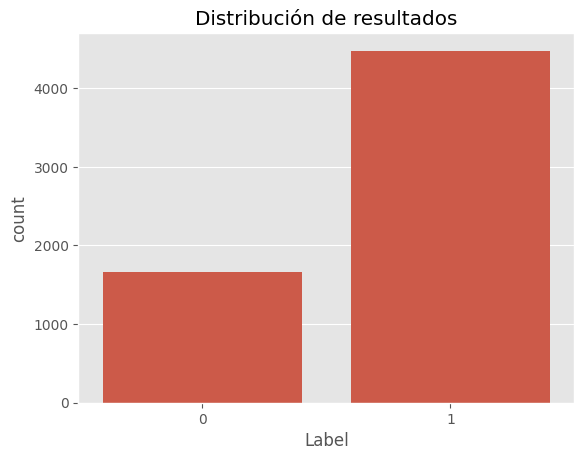

In [9]:
sns.countplot(x="Label", data=df)
plt.title("Distribución de resultados")
plt.show

In [10]:
# Se verifica si hay valores nulos
df.isna().any()

Channel    False
Counts     False
Label      False
dtype: bool

In [11]:
# Se verifica si hay valores infinitos
df.isin([np.inf, -np.inf]).any()

Channel    False
Counts     False
Label      False
dtype: bool

## 3. Boxplots e Histogramas

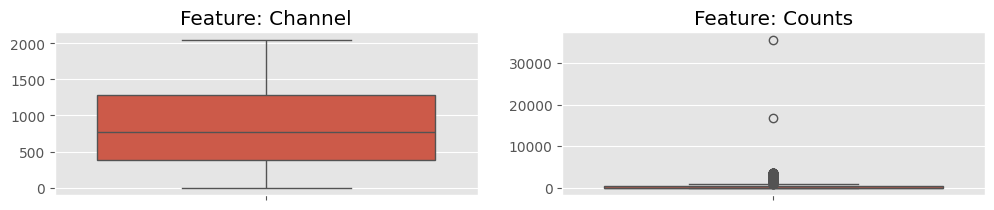

In [12]:
# Boxplots
features = df.drop(["Label"], axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Boxplots por clase
    sns.boxplot(data=df[f], ax=ax)
    ax.set_ylabel('')
    ax.set_title(f"Feature: {f}")

plt.show()

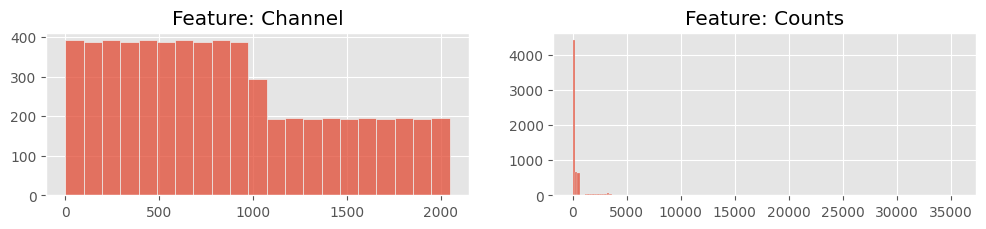

In [13]:
# Histogramas
features = df.drop(["Label"], axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Histogramas por clase
    sns.histplot(data=df[f], ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")

plt.show()

## 4. Comparacion de la variable de salida

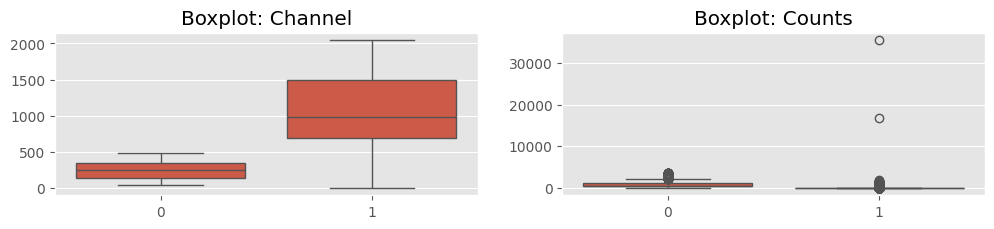

In [14]:
# Comparacion via Boxplot
features = df.drop(["Label"], axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    if f == "Counts":
        sns.boxplot(data=df, x="Label", y=f, ax=ax)
        #ax.set_ylim(0,400)
        ax.set_xlabel('')  
        ax.set_ylabel('') 
        ax.set_title(f"Boxplot: {f}")
    else:
        sns.boxplot(data=df, x="Label", y=f, ax=ax)
        ax.set_xlabel('')  
        ax.set_ylabel('') 
        ax.set_title(f"Boxplot: {f}")

plt.show()

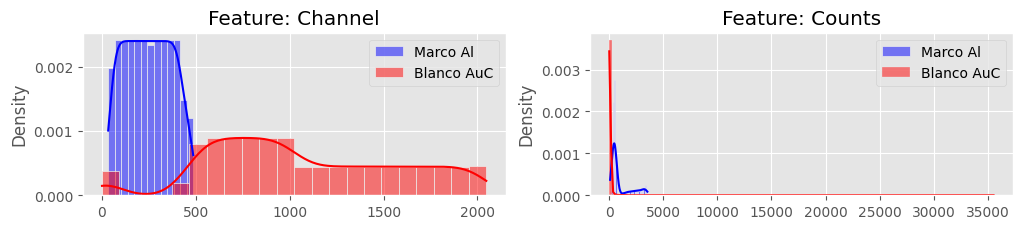

In [15]:
# Comparacion via Densidad
features = df.drop(["Label"], axis=1)

plt.figure(figsize=(12, 120))
gs = gridspec.GridSpec(32, 2)
gs.update(hspace=0.8)

for i, f in enumerate(features):
    ax = plt.subplot(gs[i])
    # Usando histplot para los casos donde Label == 0
    sns.histplot(data=df[df["Label"] == 0], x=f, kde=True, color="blue", stat="density", label="Marco Al", alpha=0.5)
    # Usando histplot para los casos donde Label == 1
    sns.histplot(data=df[df["Label"] == 1], x=f, kde=True, color="red", stat="density", label="Blanco AuC", alpha=0.5)
    ax.set_xlabel('')
    ax.set_title(f"Feature: {f}")
    ax.legend()

plt.show()

## 5. Calculo de correlaciones

In [16]:
# Calculamos correlaciones
corr_matrix = df.corr(method="spearman")
corr_matrix["Label"].sort_values(ascending=False)

Label      1.000000
Channel    0.714595
Counts    -0.813501
Name: Label, dtype: float64

In [17]:
df.corr(method="spearman")

,Channel,Counts,Label
Channel,1.000000,-0.800024,0.714595
Counts,-0.800024,1.000000,-0.813501
Label,0.714595,-0.813501,1.000000


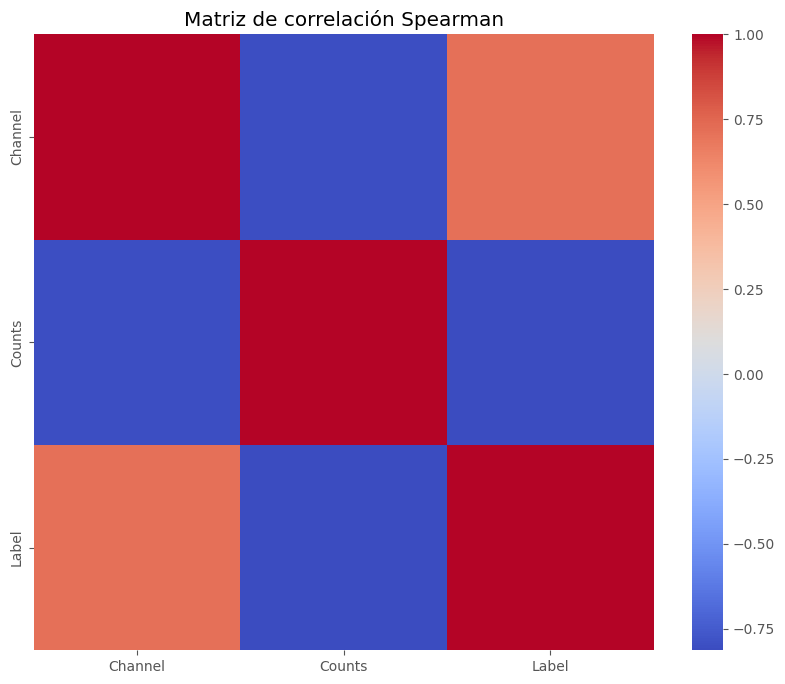

In [18]:
# Heatmap de la matriz de correlacion
corr = df[df.columns].corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Matriz de correlación Spearman")
plt.show()

## 6. Representaciones gráficas

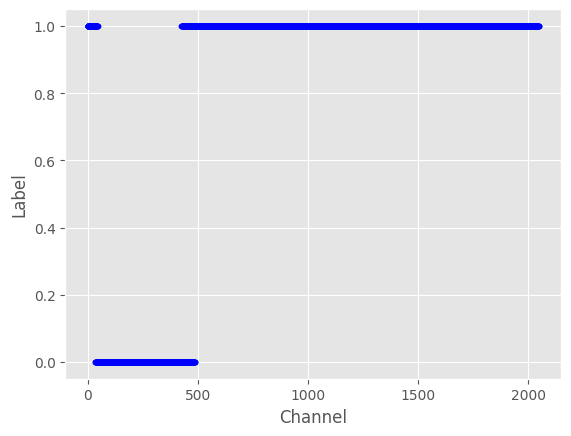

In [19]:
# Representación gráfica Channel vs Label
plt.plot(df['Channel'], df['Label'], "b.")
plt.xlabel("Channel")
plt.ylabel("Label")
plt.show()

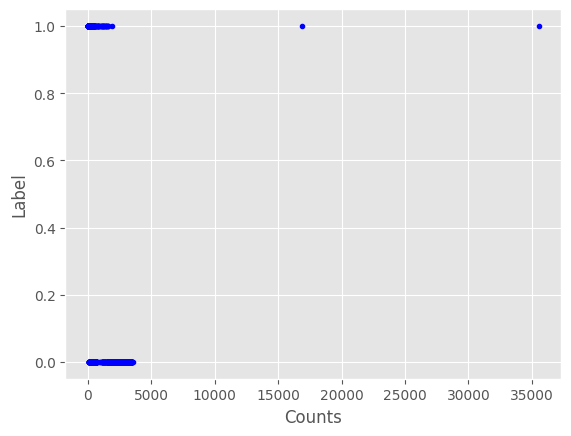

In [20]:
# Representación gráfica Counts vs Label
plt.plot(df['Counts'], df['Label'], "b.")
plt.xlabel("Counts")
plt.ylabel("Label")
plt.show()

## 7. División del conjunto de datos

In [21]:
# Se separa el conjunto de datos en tres subconjuntos: Entrenamiento, Validación y Pruebas
train_set, val_set, test_set = train_val_test_split(df)

In [22]:
# Se separan las etiquetas de entrada y de salida
X_df, y_df = remove_labels(df, "Label")

X_train, y_train = remove_labels(train_set, "Label")

X_val, y_val = remove_labels(val_set, "Label")

X_test, y_test = remove_labels(test_set, "Label")

## 8. Entrenamiento de un algoritmo de regresión logística

In [23]:
clf = LogisticRegression(
        C=0.1,
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    )

clf.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.1
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [24]:
# Predecimos con el conjunto de datos de validación
y_pred_val = clf.predict(X_val)
y_pred_val

array([1, 0, 1, ..., 1, 0, 0], shape=(1229,))

In [25]:
# Comparación de valores predecidos y reales
print("Predicción:\n", y_pred_val[:10])
print("\nEtiquetas reales:\n", y_val[:10])

Predicción:
 [1 0 1 1 1 1 1 1 0 1]

Etiquetas reales:
 3203    1
2476    0
5118    1
2892    1
3557    1
3464    1
543     1
3053    1
1157    0
4072    1
Name: Label, dtype: int64


In [26]:
from sklearn.metrics import accuracy_score

print('Accuracy para el Conjunto de datos de Validación: {:.3f}'.format(accuracy_score(y_val, y_pred_val)))

Accuracy para el Conjunto de datos de Validación: 0.964


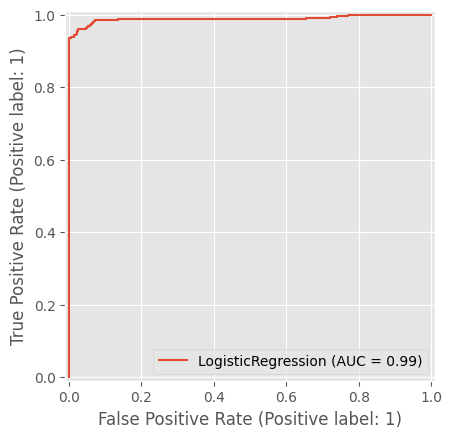

In [27]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clf, X_val, y_val)

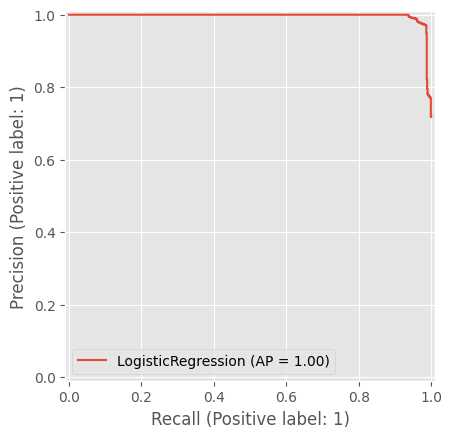

In [28]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf, X_val, y_val)

In [29]:
# Predecimos con el conjunto de datos de prueba
y_pred_test = clf.predict(X_test)
y_pred_test

array([1, 1, 1, ..., 1, 1, 1], shape=(1229,))

In [30]:
# Comparación de valores predecido y reales

print("Predicción:\n", y_pred_test[:10])
print("\nEtiquetas reales:\n", y_test[:10])

Predicción:
 [1 1 1 1 1 1 0 0 1 0]

Etiquetas reales:
 1618    1
1626    1
1983    1
1941    1
506     1
3829    1
95      0
2077    1
3877    1
4382    0
Name: Label, dtype: int64


In [31]:
print('Accuracy para el Conjunto de datos de Prueba: {:.3f}'.format(accuracy_score(y_test, y_pred_test)))

Accuracy para el Conjunto de datos de Prueba: 0.962


## 9. Optimización del modelo

In [32]:
# Pipeline
pipe = Pipeline([
    ("clf", LogisticRegression(
        solver="lbfgs",
        penalty="l2",
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

In [33]:
param_distribs = {
    'clf__C': loguniform(1e-4, 1e3),
}

rnd_search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distribs,
    n_iter=20,
    cv=5,
    scoring="f1",    
    n_jobs=-1,
    random_state=42
)

rnd_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,{'clf__C': <scipy.stats....0014FC931BA10>}
,n_iter,20
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [34]:
rnd_search.best_params_

{'clf__C': np.float64(0.041858227295469716)}

### Pipeline final

In [35]:
pipe_model = Pipeline([
        ("logreg", LogisticRegression(
        C=0.041858227295469716,
        class_weight="balanced",
        max_iter=1000,
        random_state=42
    ))
])

In [36]:
pipe_model.fit(X_train, y_train)

,steps,"[('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,0.041858227295469716
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'


## 10. Prueba del Modelo con Nuevos Datos

Se realiza una prueba del modelo final con un espectro obtenido con un haz de protones sobre el blanco ya implantado de $^{82}$Se

In [37]:
df_prueba = pd.read_excel("selenio_prueba.xlsx")

In [38]:
df_prueba

,Channel,Counts
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2043,2043,0
2044,2044,0
2045,2045,0
2046,2046,0


In [39]:
X_prueba = df_prueba[["Channel", "Counts"]]

In [40]:
# Usamos el transformador CustomScalerS
y_prueba_predict = pipe_model.predict_proba(X_prueba)[:, 1]
y_predict = (y_prueba_predict > 0.2).astype(int)

In [41]:
y_predict

array([0, 0, 0, ..., 1, 1, 1], shape=(2048,))

In [42]:
df_predict = df_prueba
df_predict["Label predict"] = y_predict
df_predict

,Channel,Counts,Label predict
0,0,0,0
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
2043,2043,0,1
2044,2044,0,1
2045,2045,0,1
2046,2046,0,1


In [43]:
df_predict["Label predict"].value_counts()

Label predict
1    1427
0     621
Name: count, dtype: int64

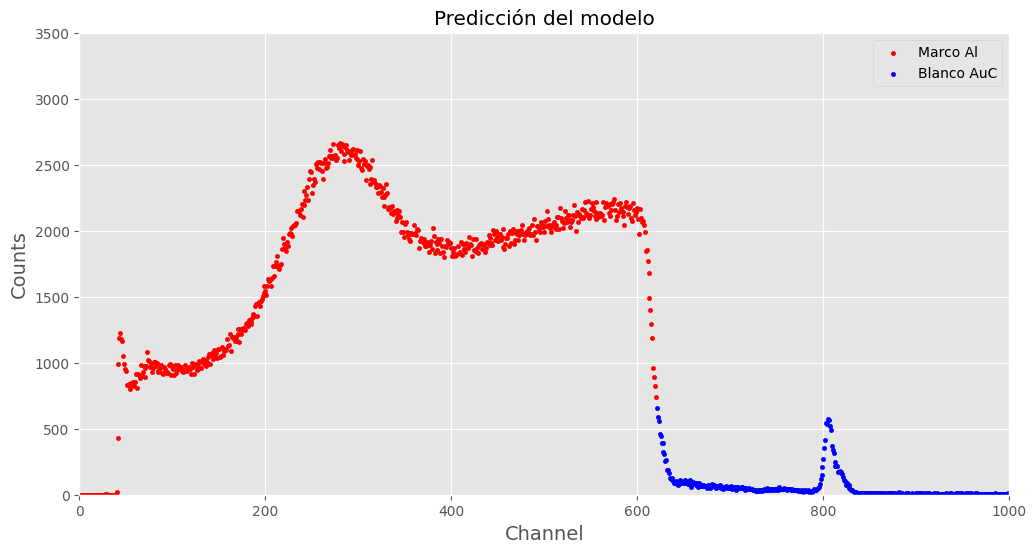

In [44]:
# Representación gráfica de la predicción del modelo
plt.figure(figsize=(12, 6))
plt.scatter(df_predict["Channel"][df_predict['Label predict'] == 0], df_predict["Counts"][df_predict['Label predict'] == 0], c="r", marker=".", label="Marco Al")
plt.scatter(df_predict["Channel"][df_predict['Label predict'] == 1], df_predict["Counts"][df_predict['Label predict'] == 1], c="b", marker=".", label="Blanco AuC")
plt.xlim(0,1000)
plt.ylim(0,3500)
plt.xlabel("Channel", fontsize=14)
plt.ylabel("Counts", fontsize=14)
plt.title("Predicción del modelo")
plt.legend()
plt.show()

## 11. Interpretación de resultados

Valores importantes:

<ul>
<li>$\text{Área del blanco}: a = \pi r^2 = \pi (0.65)^2 \approx 1.3273mm^2$</li>
<li>$\text{Radio del blanco} = 0.65mm$</li>
<li>$\text{Radio del haz} = 0.9mm$</li>
</ul>

In [45]:
# Se calcula la integral total del espectro
datos = df_predict[["Channel", "Counts"]].to_numpy()

Canal, Cuentas = datos[:, 0], datos[:, 1]

In [46]:
Integral_total = trapezoid(Cuentas, Canal)
print(Integral_total)

1068277.0


In [47]:
# Se calcula la integral de la parte impactada en el marco de aluminio
df_0 = df_predict[df_predict["Label predict"] == 0]

Canal_0 = df_0["Channel"].values
Cuentas_0 = df_0["Counts"].values

In [48]:
Integral_marco = trapezoid(Cuentas_0, Canal_0)
print(Integral_marco)

1043198.5


Para este blanco se tuvo una integral total de 1,068,277.0, y la parte de la integral en el marco es de 1,043,198.5 por lo que el área en el blanco impactada por el haz es del $2.34$%. Esto representa un alrededor de $0.03 mm^2$ de área.

La solución del problema se obtiene de:

<i>Study of the 28Si(d,α)26Al Nuclear Reaction at Low Energies, https://doi.org/10.1016/j.phpro.2017.09.044</i>

In [49]:
#Función que hace una representación gráfica del blanco y el haz
def blanco_haz(radio_blanco, radio_haz, distancia_entre_centros):
    fig, ejes = plt.subplots()
    # Se dedine el centro del blanco
    centro_blanco = (0, 0)
    # Se define el centro del haz
    centro_haz = (distancia_entre_centros, 0)
    # Se crea el blanco y el haz
    blanco = Circle(centro_blanco, radio_blanco, color='blue', alpha=0.5, label="Blanco")
    haz = Circle(centro_haz, radio_haz, color='red', alpha=0.5, label="Haz")
    ejes.add_patch(blanco)
    ejes.add_patch(haz)
    ejes.set_aspect('equal', 'box')
    ejes.set_xlim((-2,2)) , ejes.set_ylim((-2,2))
    
    plt.title('Área del blanco impactada por el haz')
    plt.xlabel('x')
    plt.ylabel('y') 
    plt.legend()
    plt.show()

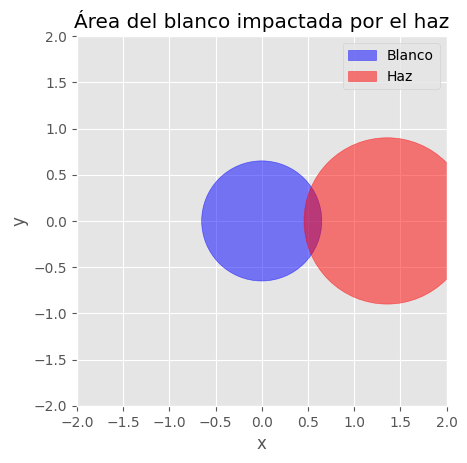

In [50]:
radio_blanco = 0.65
radio_haz = 0.9
distancia_entre_centros = 1.35839844
blanco_haz(radio_blanco, radio_haz, distancia_entre_centros)